# Cost of future subgoals model preference elicitation

This notebook contains the code used to generate the subgoal pairs and data for analysis for the third human study.

In this study, we want to see if people are sensitive to the computational costs of future subgoals. 

For each tower, we
* generate a tree of subgoal decompositions
* get the preferences over hte first subgoals across planners directly from the tree

Tower generation code is taken from `Future_costs_stim_generation.ipynb`

## Setup

In [1]:
# set up imports
import os
import sys
__file__ = os.getcwd()
proj_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(proj_dir)
utils_dir = os.path.join(proj_dir, 'utils')
sys.path.append(utils_dir)
analysis_dir = os.path.join(proj_dir, 'analysis')
analysis_utils_dir = os.path.join(analysis_dir, 'utils')
sys.path.append(analysis_utils_dir)
agent_dir = os.path.join(proj_dir, 'model')
sys.path.append(agent_dir)
agent_util_dir = os.path.join(agent_dir, 'utils')
sys.path.append(agent_util_dir)
experiments_dir = os.path.join(proj_dir, 'experiments')
sys.path.append(experiments_dir)
df_dir = os.path.join(proj_dir, 'results/dataframes')
stim_dir = os.path.join(proj_dir, 'stimuli')

In [2]:
import tower_generator

from tqdm import tqdm
import p_tqdm

import datetime

import pickle

import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.stats as stats
from scipy.stats import sem as sem

from utils.blockworld_library import *
from utils.blockworld import *

from model.BFS_Lookahead_Agent import BFS_Lookahead_Agent
from model.BFS_Agent import BFS_Agent
from model.Astar_Agent import Astar_Agent
from model.Best_First_Search_Agent import Best_First_Search_Agent
from model.Subgoal_Planning_Agent import Subgoal_Planning_Agent

from model.utils.decomposition_functions import *
import stimuli.subgoal_tree
import utils.blockworld_library as bl



In [3]:
# used for naming the output file
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Usually we would fix the random seeds here, but the agents are being run with fixed random seeds, so this is not necessary here.

In [4]:
# show all columns in dataframe
pd.set_option('display.max_columns', None)

## Generating towers


In [5]:
block_library = bl_nonoverlapping_simple

In [6]:
generator = tower_generator.TowerGenerator(8, 8,
                                           block_library=block_library,
                                           seed=3,
                                           padding=(1, 0),
                                           num_blocks=lambda: random.randint(6, 18), #  flat random interval of tower sizes (inclusive)
                                           )

In [7]:
NUM_TOWERS  = 1#128
towers = []
for i in tqdm(range(NUM_TOWERS)):
    tower = generator.generate()
    towers.append(tower)

100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


In [8]:
worlds = [Blockworld(silhouette=t['bitmap'], block_library=bl.bl_nonoverlapping_simple) for t in towers]

## Generate subgoal decompositon tree

In [9]:
MAX_LENGTH = 3

In [10]:
w = worlds[0]

In [11]:
decomposer = Rectangular_Keyholes(
    sequence_length=MAX_LENGTH,
    necessary_conditions=[
        Area_larger_than(area=1),
        # Area_smaller_than(area=30), # used to be 21
        Mass_smaller_than(area=18),
        No_edge_rows_or_columns(),
    ],
    necessary_sequence_conditions=[
        Complete(),
        No_overlap(),
        Supported(),
    ]
)

In [12]:
sga = Subgoal_Planning_Agent(lower_agent=Best_First_Search_Agent(),
                                decomposer=decomposer)

In [13]:
sga.set_world(w)

In [14]:
# sg_tree = sga.get_subgoal_tree(only_solved_sequences=True)

Filtering sequences...
Predicted number of sequences: 10696621


10696622it [02:17, 77971.38it/s]                              


Got 181 sequences:
['x:1 y:2 w:4 h:6', 'x:5 y:2 w:2 h:6']
['x:1 y:3 w:3 h:5', 'x:4 y:2 w:3 h:6']
['x:1 y:5 w:6 h:3', 'x:3 y:2 w:4 h:3']
['x:1 y:6 w:6 h:2', 'x:1 y:2 w:6 h:4']
['x:4 y:2 w:3 h:6', 'x:1 y:3 w:3 h:5']
['x:5 y:2 w:2 h:6', 'x:1 y:2 w:4 h:6']
['x:1 y:2 w:4 h:6', 'x:5 y:3 w:1 h:5', 'x:6 y:2 w:1 h:6']
['x:1 y:2 w:4 h:6', 'x:5 y:4 w:2 h:4', 'x:5 y:2 w:2 h:2']
['x:1 y:2 w:4 h:6', 'x:5 y:5 w:2 h:3', 'x:5 y:2 w:2 h:3']
['x:1 y:2 w:4 h:6', 'x:5 y:6 w:2 h:2', 'x:5 y:2 w:2 h:4']
['x:1 y:2 w:4 h:6', 'x:5 y:7 w:2 h:1', 'x:5 y:2 w:2 h:5']
['x:1 y:2 w:4 h:6', 'x:6 y:2 w:1 h:6', 'x:5 y:3 w:1 h:5']
['x:1 y:3 w:3 h:5', 'x:4 y:2 w:1 h:6', 'x:5 y:2 w:2 h:6']
['x:1 y:3 w:3 h:5', 'x:4 y:2 w:2 h:6', 'x:6 y:2 w:1 h:6']
['x:1 y:3 w:3 h:5', 'x:4 y:3 w:3 h:5', 'x:4 y:2 w:3 h:1']
['x:1 y:3 w:3 h:5', 'x:4 y:4 w:3 h:4', 'x:4 y:2 w:3 h:2']
['x:1 y:3 w:3 h:5', 'x:4 y:5 w:3 h:3', 'x:4 y:2 w:3 h:3']
['x:1 y:3 w:3 h:5', 'x:4 y:6 w:3 h:2', 'x:4 y:2 w:3 h:4']
['x:1 y:3 w:3 h:5', 'x:4 y:7 w:3 h:1', 'x:4 y:2 w:3

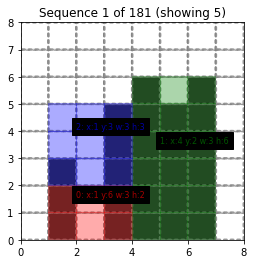

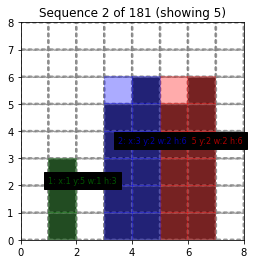

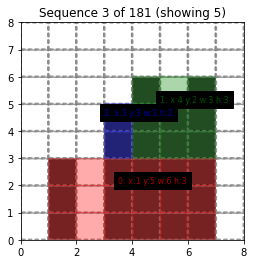

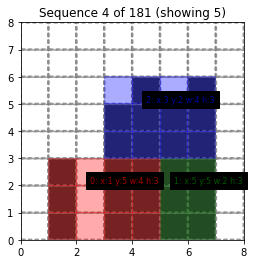

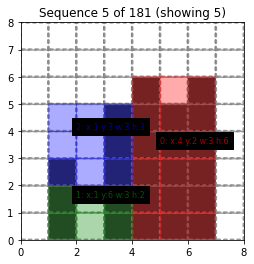

Solving sequence: ('x:1 y:2 w:4 h:6', 'x:5 y:2 w:2 h:6') 	 0 / 181
Attempted subgoal x:1 y:2 w:4 h:6 on attempt 1 with result ('Win', 'None') and total cost 6
For sequence 1 / 181 ('x:1 y:2 w:4 h:6', 'x:5 y:2 w:2 h:6') scored subgoal 1 / 2 named x:1 y:2 w:4 h:6 with C:6  R:14.0  actions:[(<utils.blockworld.BaseBlock object at 0x7fe5307d8e50>, 1), (<utils.blockworld.BaseBlock object at 0x7fe5307d8e50>, 3), (<utils.blockworld.BaseBlock object at 0x7fe5307d8e50>, 4), (<utils.blockworld.BaseBlock object at 0x7fe5307d8e50>, 4), (<utils.blockworld.BaseBlock object at 0x7fe5307d8340>, 3)]
Attempted subgoal x:5 y:2 w:2 h:6 on attempt 1 with result ('Win', 'None') and total cost 5
For sequence 1 / 181 ('x:1 y:2 w:4 h:6', 'x:5 y:2 w:2 h:6') scored subgoal 2 / 2 named x:5 y:2 w:2 h:6 with C:5  R:11.0  actions:[(<utils.blockworld.BaseBlock object at 0x7fe5307f1790>, 5), (<utils.blockworld.BaseBlock object at 0x7fe5307f1790>, 6), (<utils.blockworld.BaseBlock object at 0x7fe5307f1790>, 6), (<utils.b

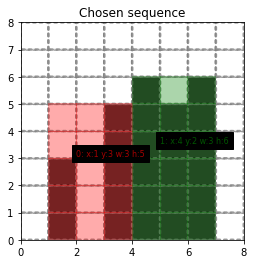

In [15]:
_, all_sequences, solved_sequences = sga.plan_subgoals(verbose=True)

In [24]:
def size_of_tree(tree):
    if type(tree) == stimuli.subgoal_tree.SubgoalTree:
        tree = tree.root
    return 1 + sum([size_of_tree(child) for child in tree.children])

In [25]:
# size_of_tree(sg_tree)

In [26]:
# sg_tree

In [27]:
# # plot all the children in a combined plot
# n_children = len(sg_tree.root.children)
# # make empty fig
# fig, axs = plt.subplots(1, n_children, figsize=(n_children*4,4))
# # plot each child
# for i, child in enumerate(sg_tree.root.children):
#     child.subgoal.visualize(title=i, ax = axs[i])

In [59]:
[s.V() for s in solved_sequences if s.solution_cost()].count(None)

0

## Generate sequences of different length

1. Use the tree to generate sequences of subgoals up to a certain length
2. Calculate V for each sequence from C, reward\
    What do we do about `c_weight`?
3. Over all sequences of a length, get list of V's for the first subgoal
4. Use the list of V's to calculate preferences over the first subgoals

In [171]:
SOFTMAX_K = 1

In [223]:
# generate subsequences
length_sequences = {}
for length in list(range(1, MAX_LENGTH+1)):
    length_sequences[length] = []
    for seq in solved_sequences: # needs to be solved sequences to ensure that they're all solvable and result in the full decompositon (make sure the proper flag is set above)
        if len(seq) <= length:
            length_sequences[length].append(seq)
        elif len(seq) > length:
            # generate a truncated sequence
            shortenend_seq = Subgoal_sequence(seq.subgoals[0:length])
            length_sequences[length].append(shortenend_seq)
    # clear out duplicates according to subgoals
    seen = set()
    length_sequences[length] = [x for x in length_sequences[length] if not (x.names() in seen or seen.add(x.names()))] # I assume that a tuple of the same objects is the same even when recreated


In [224]:
# how many sequences are there for each length?
for length in length_sequences:
    print(f'length {length}: {len(length_sequences[length])}')
    

length 1: 25
length 2: 86
length 3: 86


In [225]:
subgoals = {} # so we can look up the subgoal by name

In [226]:
# get first subgoal V's
subgoal_depth_Vs = {}
for depth in length_sequences:
    subgoal_depth_Vs[depth] = {}
    for seq in length_sequences[depth]:
        if seq.subgoals[0].name in subgoal_depth_Vs[depth]:
            subgoal_depth_Vs[depth][seq.subgoals[0].name] += [seq.V()]
        else:
            subgoal_depth_Vs[depth][seq.subgoals[0].name] = [seq.V()]
        if seq.subgoals[0].name not in subgoals:
            subgoals[seq.subgoals[0].name] = seq.subgoals[0]


In [227]:
# get list of preferences for depth per subgoal
subgoal_preferences = {}
for subgoal_name in subgoals.keys():
    subgoal_preferences[subgoal_name] = {}
    for depth in length_sequences:
        # get subgoal preference for depth
        # using softmax with K defined above
        total_best_V = [max(vs) for vs in subgoal_depth_Vs[depth].values()]
        sg_V = max(subgoal_depth_Vs[depth][subgoal_name])
        softmax_val = math.exp(SOFTMAX_K * sg_V) / sum([math.exp(SOFTMAX_K * v) for v in total_best_V])
        subgoal_preferences[subgoal_name][depth] = softmax_val

In [228]:
subgoal_preferences

{'x:1 y:2 w:4 h:6': {1: 0.08046357509306462,
  2: 0.2011569208158227,
  3: 0.12347278603502328},
 'x:1 y:3 w:3 h:5': {1: 0.0014737417851011173,
  2: 0.2011569208158227,
  3: 0.12347278603502328},
 'x:1 y:5 w:6 h:3': {1: 0.2187226740283274,
  2: 0.010015013369326359,
  3: 0.04542309952644543},
 'x:4 y:2 w:3 h:6': {1: 0.5945498702831735,
  2: 0.2011569208158227,
  3: 0.12347278603502328},
 'x:5 y:2 w:2 h:6': {1: 0.010889560725450356,
  2: 0.2011569208158227,
  3: 0.12347278603502328},
 'x:1 y:5 w:1 h:3': {1: 7.337328301140717e-05,
  2: 0.010015013369326359,
  3: 0.04542309952644543},
 'x:1 y:5 w:3 h:3': {1: 0.0005421593043340029,
  2: 0.07400149561749293,
  3: 0.04542309952644543},
 'x:1 y:5 w:4 h:3': {1: 0.0040060455142811625,
  2: 0.010015013369326359,
  3: 0.04542309952644543},
 'x:1 y:5 w:5 h:3': {1: 0.029600895039892997,
  2: 0.003684317521632305,
  3: 0.0003060584371433735},
 'x:3 y:2 w:2 h:6': {1: 0.010889560725450356,
  2: 0.027223628853614238,
  3: 0.04542309952644543},
 'x:3 y:

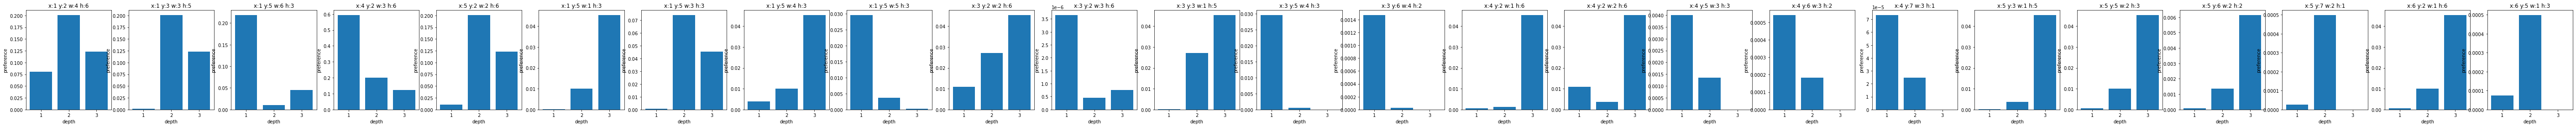

In [229]:
# let's show every subgoal with a bar plot of its preferences
# for each depth
# on a grouped bar plot
# get the subgoal names
subgoal_names = list(subgoal_preferences.keys())
fig, axes = plt.subplots(1, len(subgoal_names), figsize=(len(subgoal_names)*4,4))
# get the depths
depths = list(subgoal_preferences[subgoal_names[0]].keys())
# get the preferences
values = np.array([[subgoal_preferences[sg_name][depth] for depth in depths] for sg_name in subgoal_names])
for i, subgoal_name in enumerate(subgoal_names):
    axes[i].bar(depths, values[i,:])
    axes[i].set_title(subgoal_name)
    # axes[i].set_ylim([0,1])
    axes[i].set_xlabel('depth')
    axes[i].set_ylabel('preference')
plt.show()


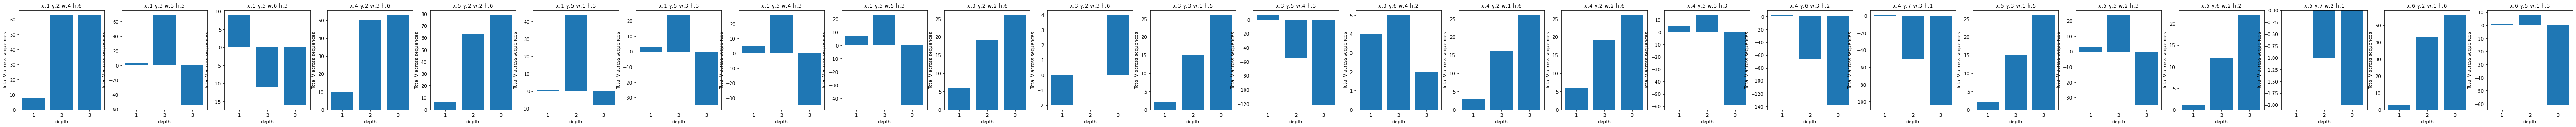

In [230]:
# let's show every subgoal with a bar plot of its total value (ie. the total V across attempts on the subgoal)
# for each depth
# on a grouped bar plot
# get the subgoal names
subgoal_names = list(subgoal_preferences.keys())
fig, axes = plt.subplots(1, len(subgoal_names), figsize=(len(subgoal_names)*4,4))
# get the depths
depths = list(subgoal_preferences[subgoal_names[0]].keys())
# get the preferences
values = np.array([[sum(subgoal_depth_Vs[depth][sg_name]) for depth in depths] for sg_name in subgoal_names])
for i, subgoal_name in enumerate(subgoal_names):
    axes[i].bar(depths, values[i,:])
    axes[i].set_title(subgoal_name)
    # axes[i].set_ylim([0,1])
    axes[i].set_xlabel('depth')
    axes[i].set_ylabel('Total V across sequences')
plt.show()


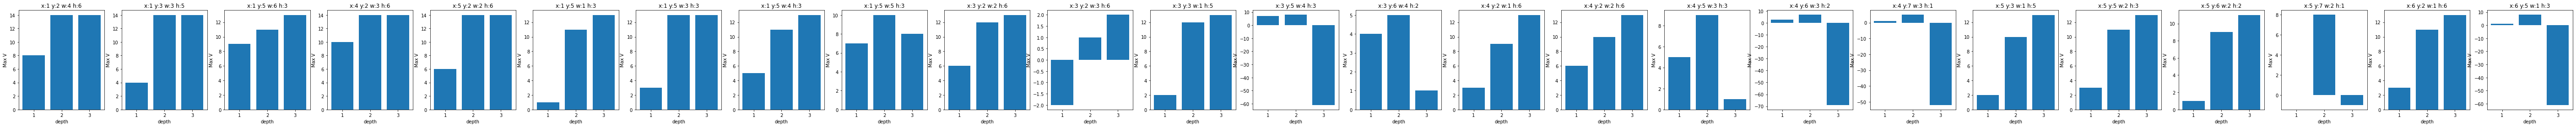

In [231]:
# let's show every subgoal with a bar plot of its maximum V
# for each depth
# on a grouped bar plot
# get the subgoal names
subgoal_names = list(subgoal_preferences.keys())
fig, axes = plt.subplots(1, len(subgoal_names), figsize=(len(subgoal_names)*4,4))
# get the depths
depths = list(subgoal_preferences[subgoal_names[0]].keys())
# get the preferences
values = np.array([[max(subgoal_depth_Vs[depth][sg_name]) for depth in depths] for sg_name in subgoal_names])
for i, subgoal_name in enumerate(subgoal_names):
    axes[i].bar(depths, values[i,:])
    axes[i].set_title(subgoal_name)
    # axes[i].set_ylim([0,1])
    axes[i].set_xlabel('depth')
    axes[i].set_ylabel('Max V')
plt.show()
